In [1]:
%load_ext lab_black
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
import matplotlib.pyplot as plt
from src.linear_coef_matching import LCM
from src.linear_coef_matching_mf import LCM_MF
from other_methods import prognostic
from Experiments.helpers import get_data
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
np.random.seed(0)
config = {
    "num_samples": 5000,
    "imp_c": 5,
    "unimp_c": 15,
    "imp_d": 0,
    "unimp_d": 0,
    "n_train": 3000,
}
df_train, df_est, df_true, binary = get_data(data="dense_continuous", config=config)

In [3]:
prog = prognostic.Prognostic(
    "Y", "T", df_train, method="linear", double=True, random_state=0
)
_, c_mg, t_mg = prog.get_matched_group(df_est, k=25, diameter_prune=None)
mg = c_mg.join(t_mg, lsuffix="_c")

lcm = LCM("Y", "T", df_train)
lcm.fit()


def lcm_cates(row, df, lcm):
    idx = row.name
    matches = row.values
    df_ = df.loc[matches]
    cates = lcm.CATE(df_estimation=df_, k=1, diameter_prune=None)
    cate_df = pd.DataFrame(cates)
    cate_df["idx"] = matches
    return cate_df.loc[cate_df["idx"] == idx, "CATE_mean"].values[0]


combo_cates_lin = mg.apply(lcm_cates, df=df_est, lcm=lcm, axis=1)

0.9978338114057859
0.9814426306978918


In [4]:
prog = prognostic.Prognostic(
    "Y", "T", df_train, method="ensemble", double=True, random_state=0
)
_, c_mg, t_mg = prog.get_matched_group(df_est, k=25, diameter_prune=None)
mg = c_mg.join(t_mg, lsuffix="_c")

lcm = LCM("Y", "T", df_train)
lcm.fit()


def lcm_cates(row, df, lcm):
    idx = row.name
    matches = row.values
    df_ = df.loc[matches]
    cates = lcm.CATE(df_estimation=df_, k=1, diameter_prune=None)
    cate_df = pd.DataFrame(cates)
    cate_df["idx"] = matches
    return cate_df.loc[cate_df["idx"] == idx, "CATE_mean"].values[0]


combo_cates_gbt = mg.apply(lcm_cates, df=df_est, lcm=lcm, axis=1)

0.9865950425146214
0.9859835666398188


In [5]:
cates = lcm.CATE(df_estimation=df_est, k=1, diameter_prune=None)
cate_df = pd.DataFrame(cates)

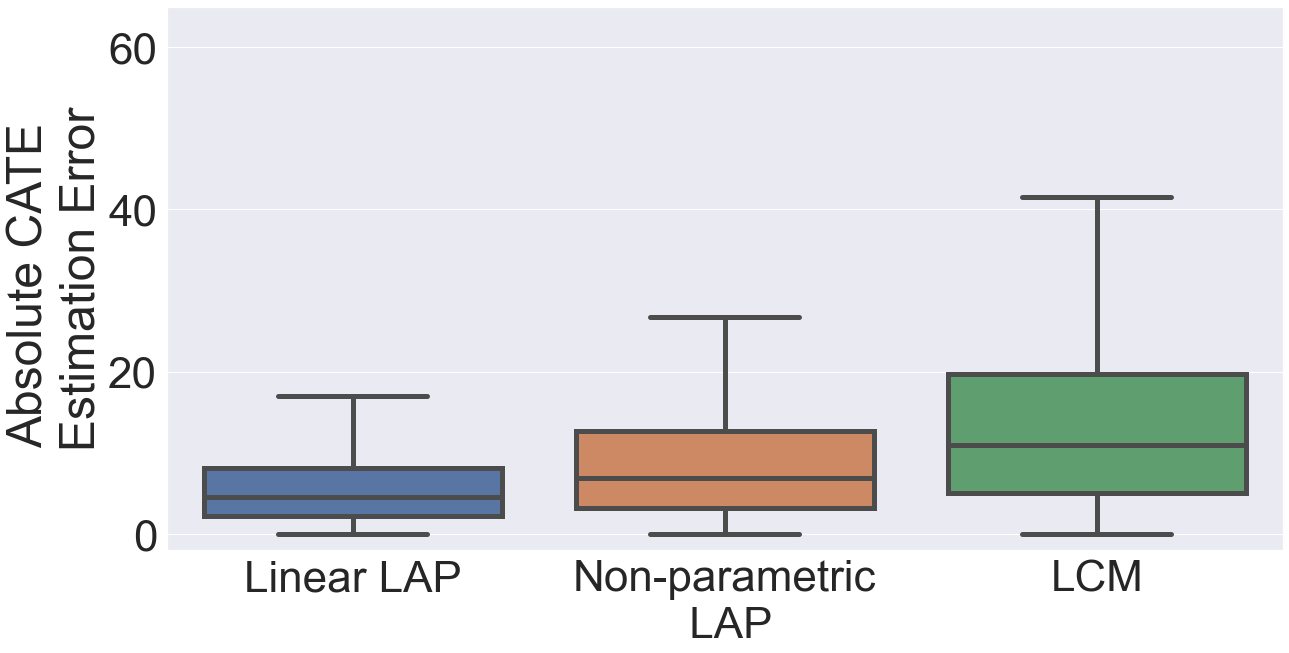

In [86]:
sns.set(font_scale=4)
fig, ax = plt.subplots(figsize=(20, 10))
df_res = pd.DataFrame()
df_res["Linear LAP"] = np.abs(combo_cates_lin - df_true["TE"])
df_res["Non-parametric\n LAP"] = np.abs(combo_cates_gbt - df_true["TE"])
df_res["LCM"] = np.abs(cate_df["CATE_mean"] - df_true["TE"])
sns.boxplot(data=df_res, fliersize=0, ax=ax, linewidth=5)
plt.xticks(rotation=0)
plt.ylabel("Absolute CATE \nEstimation Error")
plt.ylim(-2, 65)
plt.savefig("combining_pgm_w_lcm_results.png")
df_res.to_csv("combining_pgm_w_lcm_results.csv")
# plt.boxplot(np.abs(combo_cates - df_true["TE"]), positions=[1])
# plt.boxplot(np.abs(cate_df["CATE_mean"] - df_true["TE"]), positions=[2])

In [21]:
std_aug = []
std_lcm = []
for idx in df_est.index:
    mg_0 = lcm.get_matched_groups(df_estimation=df_est.loc[mg.loc[idx]], k=1)
    a = set(mg_0[0][0].loc[0]).union(mg_0[0][1].loc[0])
    df_est.loc[mg.loc[idx]].iloc[list(a)]

    mg_1 = lcm.get_matched_groups(df_estimation=df_est, k=1)
    b = set(mg_1[0][0].loc[idx]).union(mg_1[0][1].loc[idx])

    std_aug.append(df_est.loc[mg.loc[idx]].iloc[list(a)].std().drop(["Y", "T"]).values)
    std_lcm.append(df_est.loc[b].std().drop(["Y", "T"]).values)

std_aug = np.array(std_aug)
std_lcm = np.array(std_lcm)

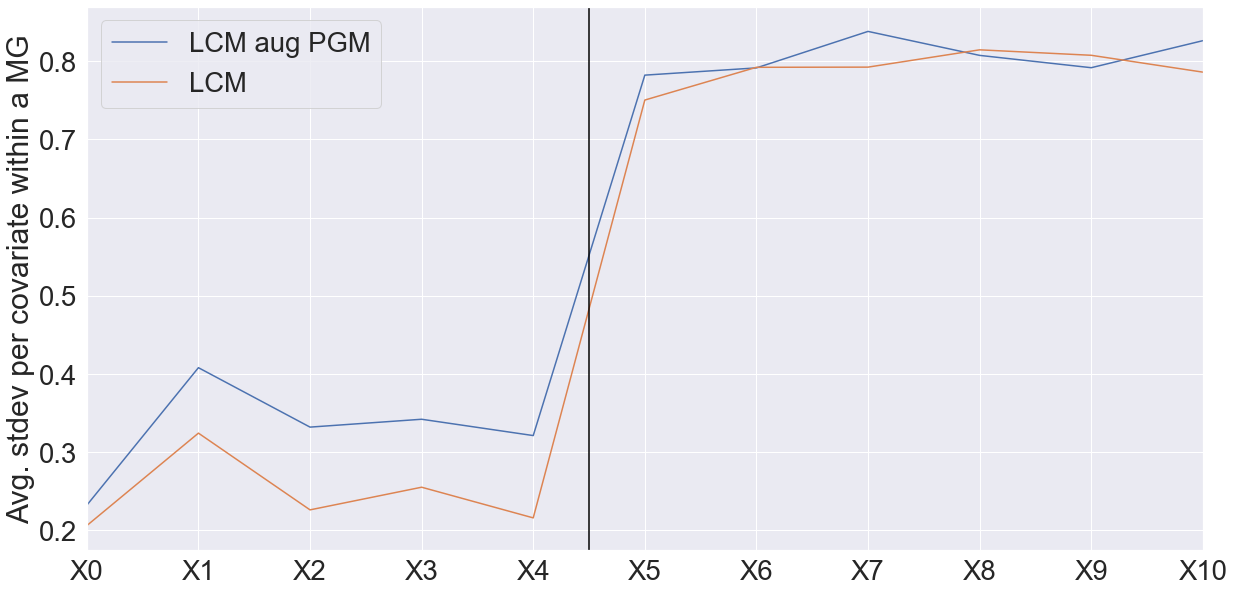

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
pd.DataFrame(std_aug, columns=df_est.drop(columns=["Y", "T"]).columns).mean().plot()
pd.DataFrame(std_lcm, columns=df_est.drop(columns=["Y", "T"]).columns).mean().plot()
plt.axvline(4.5, c="black")
plt.xticks(
    np.arange(0, len(df_est.loc[a].std().drop(["Y", "T"]).index)),
    df_est.loc[a].std().drop(["Y", "T"]).index,
)
plt.xlim(0, 10)
plt.legend(["LCM aug PGM", "LCM"])
plt.ylabel("Avg. stdev per covariate within a MG")
plt.savefig("aug_pgm_matched_tight.png")

In [20]:
df_est.loc[mg.loc[idx]].iloc[list(a)]

,Y,T,X0,X1,X2,X3,X4,X5,X6,X7,...,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
1937,41.136113,0,0.218332,-0.463230,0.483146,-0.644566,0.503126,-0.900626,0.374506,-1.100526,...,0.096145,1.698395,-0.580537,-0.190521,0.914792,2.021450,0.367288,-0.804787,-0.370073,0.598636
1378,54.892823,1,0.362891,-0.587909,0.986812,-0.642900,-0.043243,0.094061,-0.597369,-1.388051,...,-1.360756,-0.759986,1.918716,-0.537838,-0.286854,-1.108019,1.934309,-2.721566,0.054737,1.652527


In [83]:
df_std_aug = (
    pd.DataFrame(std_aug, columns=df_est.drop(columns=["Y", "T"]).columns)
    .stack()
    .reset_index()
    .assign(Method=lambda x: "Non-parametric LAP")
    .rename(
        columns={0: "avg. stdev per covariate within a MG", "level_1": "covariates"}
    )
)
df_std_lcm = (
    pd.DataFrame(std_lcm, columns=df_est.drop(columns=["Y", "T"]).columns)
    .stack()
    .reset_index()
    .assign(Method=lambda x: "LCM")
    .rename(
        columns={0: "avg. stdev per covariate within a MG", "level_1": "covariates"}
    )
)

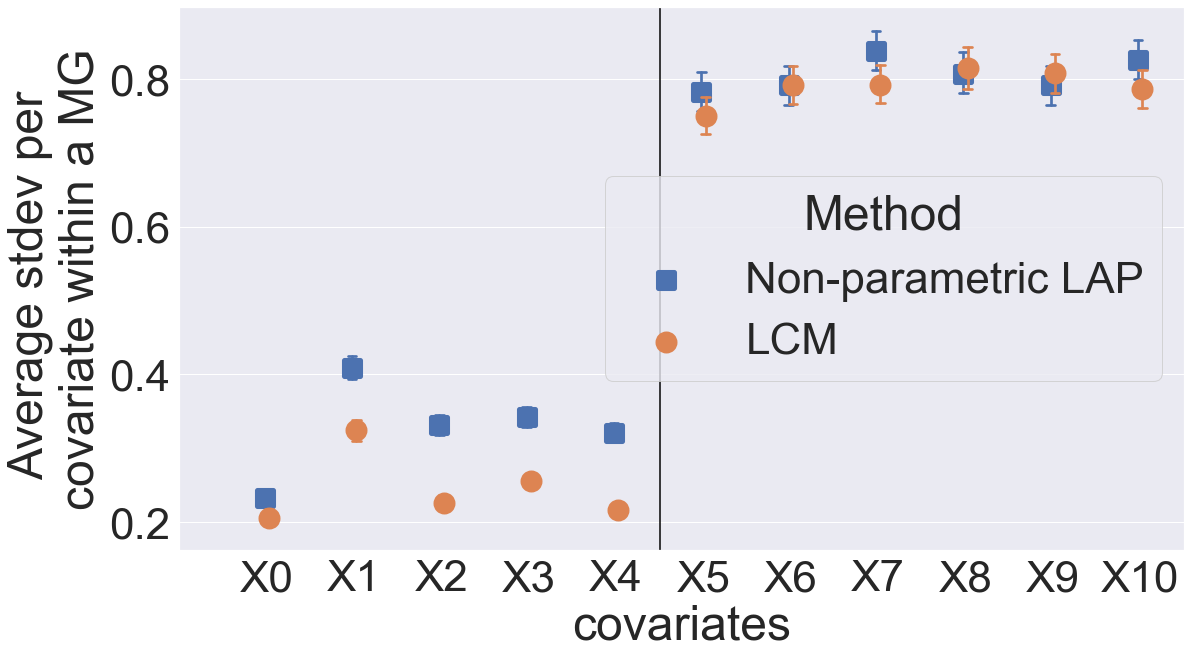

In [84]:
sns.set(font_scale=4)
fig, ax = plt.subplots(figsize=(18, 10))
sns.pointplot(
    x="covariates",
    y="avg. stdev per covariate within a MG",
    data=df_std_aug.append(df_std_lcm),
    join=False,
    hue="Method",
    dodge=True,
    scale=2.5,
    capsize=0.1,
    markers=["s", "o"],
)
plt.axvline(4.5, c="black")
# plt.xticks(
#     np.arange(0, len(df_est.loc[a].std().drop(["Y", "T"]).index)),
#     df_est.loc[a].std().drop(["Y", "T"]).index,
# )
ax.set_xlim(-1, 10.5)
plt.ylabel("Average stdev per \ncovariate within a MG")
plt.savefig("aug_pgm_matched_tight.png")